# Using SAS DLPy to Create a SAS Viya RNN Image Captioning Model

The following example demonstrates how to create a SAS Viya RNN Image Captioning model using the SAS DLPy API. The example begins by downloading required Python utilities and deep learning model resources. After downloading the task's input images and input image captions, the notebook creates two CNN models: a VGG-16 CNN model designed to output an extracted numeric features table, and a YoloV2 Multisize CNN model designed to output numeric detected object data table. The image captions table, the VGG-16 output image features table, and the YoloV2 output numeric detected object table are merged into a single table. The merged table with captions, features, and objects indexed by input image filename becomes the training data for a third model: an RNN image captioning model. The RNN image captioning model architecture is defined in SAS DLPy, trained using the merged input data table, and then used to score input image data and generate captions for each image in the collection.

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the Image Data](#downloadData)
    - [Download the Image Captions File](#downloadCaptions)
    - [Download a Pre-Trained Word Vector File](#downloadEmbeddings)
    - [Format the Pre-Trained Word Vector File for Modeling](#addColHeadings)
    - [Download the VGG-16 Model and Weights](#VGG16)
    - [Download the YoloV2 Multisize Model and Weights](#YoloV2Multisize)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Connect to a SAS CAS Session](#connnectCAS)
- [Load and Process the Input Images in SAS CAS](#loadInputs)
- [Load Image Captions into SAS CAS](#captions)
- [Load VGG-16 Model and Extract Image Features](#features)
- [Load YoloV2 Model and Extract Detected Objects](#detection)
- [Merge Captions, Features, and Detected Objects Tables](#merge)
- [Create Image Captioning Model Training Data in a Single Step](#oneStep)
- [Use SAS DLPy to Create a SAS Viya Image Captioning Model](#RNNmodel)
- [Train the SAS Viya Image Captioning Model](#trainRNN)
- [Score the Image Captioning Table](#scoreCaptioningTable)
- [Display Image Captioning Predictions](#displayPredictions)

<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.


In [1]:
# This code defines path variables that contain path specifications to  
# the client and server machine weight files and image root directories

# Server Image Captioning root location (your path will be different)
server_image_captioning_root = r'/cas/DeepLearn/UserID/Image_Captioning/' 

# Server Image Captioning Image root location (your path will be different)
server_image_captioning_image_root = r'/cas/DeepLearn/userID/Image_Captioning/imageCaptioning_images' 

# Client Image Captioning root location (your path will be different)
client_image_captioning_root = r'\\network\data\DeepLearn\userID\Image_Captioning'

# Client Image Captioning Image root location (your path will be different)
client_image_captioning_image_root = r'\\network\data\DeepLearn\userID\Image_Captioning\imageCaptioning_images'


<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources that you will need and configure your local computing environment for this notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Image Data

This example notebook uses a small input image data set in a folder `imageCaptioning_images`. The folder (~36 MB) contains 50 .jpg images of varying sizes and dimensions. You can clone or download the image data folder from the [SAS DLPy GitHub repository](https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/imageCaptioning_images). (The captions file for these images is downloaded in the next step.)

Copy (or unzip) the DLPy `imageCaptioning_images` folder from your preferred source to the server-side folder specified in the `server_image_captioning_root` variable.

<a id="downloadCaptions"></a>

#### Download the Image Captions File

Image captioning models use a captions file to associate caption content with input data images. The content in the file is a table of captions indexed by image filename. The caption file `image_captions.txt` is  for the .jpg images in the `imageCaptioning_images` folder. 

Clone or download `image_captions.txt` from the [SAS DLPy datasources folder](https://github.com/sassoftware/python-dlpy/blob/master/dlpy/tests/datasources/image_captions.txt) on GitHub. Copy the `image_captions.txt` file to the client computer path that you specified previously in `client_image_captioning_root`.

<a id="downloadEmbeddings"></a>

#### Download a Pre-Trained Word Vector File

Image captioning is one of many NLP machine learning tasks that use a pre-trained word vector file (word-level embedding file). Word embedding models output trained word vector files. Word vector files (or word embeddings) map word and prhase data into numeric vector data. The content of word vector files varies with the input training text corpus, depending on the corpus scope, content, tokenization, and size. 

The quality of word vector files increases with the size of the training data they contain. Word vector files also scale by providing different numbers of vector dimensions for each word. A typical word vector file might have 50, 100, 200, or 300 dimensions for each entry. More dimensions in a vector file can increase predictive accuracy, offset by the increase in  model complexity and larger processing times. 

Pre-trained word embeddings are an example of transfer learning. A word embeddings model first performs extensive trainining on a massive input corpus of text. Once the extensive training investment is complete, the output word vector file can be used as a feature in numerous other NLP models without the significant initial training cost. 

Word embedding models use a diverse variety of input text sources for model training. For example, the well-known [Word2Vec](https://code.google.com/archive/p/word2vec/) project in the Google Code Archive includes a model that was trained on a Google News data set of about 100 billion words. The output is a large downloadable word vector file archive GoogleNews-vectors-negative300.bin.gz (1.5 GB) that contains 300 dimensions for 3 million English language words and phrases. You can choose a different text corpus to train Word2Vec: the [Google code archive](https://code.google.com/archive/p/word2vec/) includes links to five other online text corpora that range in size from 1 billion to 3 billion words. The diverse corpora sources include aggregated European News Commentary archives, Wikipedia content dumps, Gigaword repositories in multiple languages, and the historical base from the UMBC (University of Maryland, Baltimore Campus) web archives.   

<b>Note:</b> The Google Word2Vec research project is not a Google product. Word2Vec is licensed for use according to the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) agreement.    

Another well-known word embeddings source is the [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) (Global Vectors for Word Representation) unsupervised learning algorithm developed by Jeffrey Pennington, Richard Socher, and Christopher D. Manning of Stanford University. GloVe models train by determining global word-word co-occurrence statistics from a large text corpus. The Stanford [GloVe site](https://nlp.stanford.edu/pubs/glove.pdf) features a number of word vector archives that were trained on different sizes and types of text corpora. The GloVe site files can be downloaded for use as specified in the [Public Domain Dedication and License v1.0](http://www.opendatacommons.org/licenses/pddl/1.0/) document. 

For example, the [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB) word vector archive files were trained on the the Wikipedia 2014 + Gigaword 5 corpus. It features 6 billion tokens and a 400,000 word uncased vocabulary. The archive includes four separate trained word vector files that have 50, 100, 200, and 300 dimensions, respectively. 

Numerous available word embedding algorithms and software products provide trained word vector files that are suitable for tutorial and research modeling consumption. This example does not require a specific word vector table from any specific provider: the choice of provider and word vector file is left to the modeler.

The toy input data set used in this example is relatively small, so a trained word vector file with 100 dimensions is more than sufficient. (A 50-dimension word vector file would suffice, but considering the small size of the training data, the increase to 100 dimensions is a trade-off to improve model performance.) The 100-dimension word vector file used in this example was  formatted by adding column header information and cleansing the index column. The resulting file is saved as `word_embeddings.txt`. This notebook includes code that you can use to format your choice of trained word vector file.)

The structure of the word vector file `word_embeddings.txt` used in this example resembles the 100-dimension trained word vector file `glove.6B.100d.txt` that is included in Stanford's Wikipedia 2014 + Gigaword 5 [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) archive. However, you should be able to format and use any one of a number of available trained 100-dimension word vector files to use with this notebook and deliver fundamentally equivalent predictive results. 

Copy the word vector file of your choice to the folder location you specified earlier as `server_image_captioning_root`. The following example section provides code that you can use to format the word vector data for modeling.

<a id="addColHeadings"></a>

#### Format the Word Vector File for Modeling

Word embedding files typically contain sequential delimited term and vector data in a flat file. The flat file is formatted for model consumption by creating a word vector table with column headings, and then the table is cleansed by removing rows that have forbidden index column values (e.g., quotation marks). The table header row consists of a `term` column, followed by sequential integer headings for each dimension column in the table. For example, a formatted 100-dimension word vector file has the following column headings: " term , _1_ , _2_ , ... , _99_ , _100_". The `term` column contains character and word strings. The numeric columns contain word vector values for the specified dimension. The number of rows in the table is determined by the size of the source corpus. 

If your chosen word vector file is not formatted and cleansed, you can use the following code to format a "raw" downloaded word vector file into a table indexed by term, with sequential numbered columns for every dimension of word vector values. The code also removes table rows for index entries that have reserved or forbidden character string values.

Note: Word vector files can be large. A typical 100-dimension word vector file for a corpus of 400,000 terms with 100 vector values per term is a table with over 40 million values. Adjust your expectations for the computation time accordingly. The required time to format a word vector file for modeling using the code below scales with the number of dimensions in the raw embedding file.

In [2]:
# Most open-source word vector files do not have formatted column headings.
# (Use a file viewer to check for column headings and table structdure.)
# You can skip this section if your word vector file already has been cleansed
# and appropriately formatted for modeling.

# Import pandas 
import pandas as pd

# Import csv
import csv

# Import os
import os

# Save the word vector file full path spec to the variable 'raw_embedding_file'.
# This example expects a 100-dimension trained word vector file in .txt format. 
raw_embedding_file = os.path.join(client_image_captioning_root,'<100d-source-word-vector-filename.txt>')

# The 'raw_embedding_dimension' parameter should match the  
# number of dimensions in the preferred word vector file:

# For a 50-dimension word vector file
# raw_embedding_dimension = 50

# For a 100-dimension word vector file
raw_embedding_dimension = 100

# Use variable 'col_names' to accumulate the 
# generated header strings for all table columns.
col_names = ['term'] + ['_'+str(ii)+'_' for ii in range(1,raw_embedding_dimension+1)]

# Pandas reads in the tab-delimited embedding values
# from the word vector file with no header
df = pd.read_csv(raw_embedding_file, 
                 names=col_names,
                 sep=" ", 
                 index_col=0, 
                 header=None,
                 quoting=csv.QUOTE_NONE)


# Clean up and omit rows in the table that have 
# reserved or forbidden index character strings.
tmp = [str(df.index[ii]) for ii in range(df.shape[0])]
idx = [ii for ii,txt in enumerate(tmp) if ('"' not in txt) and ("'" not in txt)]
df1 = df.iloc[idx]

# Save the updated 100-dimension table with column headings  
# as a new tab-delimited file named 'word_embeddings_100.txt'. 
# Store the full client-side path specification for the word vector file 
# in the variable 'pretrained_embedding_file'.

pretrained_embedding_file = os.path.join(client_image_captioning_root,'word_embeddings_100.txt')
df1.to_csv(pretrained_embedding_file, 
           sep='\t', 
           header=True,
           float_format='%5.6f',
           index=True,
           quoting=csv.QUOTE_NONE)

<a id='VGG16'></a>

#### Download the VGG-16 Model and Weights

This example section begins with an open-source pre-trained VGG-16 Caffe model named `VGG_ILSVRC_16_layers.caffemodel.h5`. The VGG-16 model used in this notebook can be downloaded from the [SAS Deep Learning Models and Tools Page](https://support.sas.com/documentation/prod-p/vdmml/zip/) in a .zip archive [here](https://support.sas.com/documentation/prod-p/vdmml/zip/vgg16.zip). The VGG-16 model in this example performs feature extraction on the input images data set and outputs an extracted features table. The features table will eventually become part of the training data for the RNN image captioning model this notebook creates. 

Expand the contents of the zip archive file to the server-side folder that you specified in the `server_image_captioning_root` variable.

<a id='YoloV2Multisize'></a>

#### Download the YoloV2 Multisize Model and Weights

This example section uses an open-source pre-trained YoloV2 Multisize model for 313 class objects. The model is a general object detector trained on a subset of the OpenImagev4 data set. 

The `yolov2_multisize_313cls` model is based on the full size YoloV2-Multisize model and is designed to consume 416px by 416px images. Download the YoloV2 Multisize model in an archive file from the [SAS Support Site Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) page. The direct link to download the model in SAS distrbuted Hadoop (`.sashdat`) file format [here](https://support.sas.com/documentation/prod-p/vdmml/zip/yolov2_multisize_313cls.zip). The YoloV2 Multisize model in this section extracts detected objects in the input data and outputs a detected objects table. The detected objects table will eventually become part of the training data for the RNN image captioning model this notebook creates.

Expand the contents of the archive file `yolov2_multisize_313cls.zip` to the server-side folder that you specified in the `server_image_captioning_root` path variable. The archive creates a sub-folder named `yolov2_multisize_313cls`, which in turn contains the model and weight files `YoloV2_Multisize.sashdat` and `YoloV2_Multisize_weights.sashdat`. These files are needed during the Object Detection step in this notebook. 

<a id = "importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

After copying the input image data to your server, configure your client computing environment for image captioning modeling using Python and SAS DLPy. 

Import the various Python and SAS DLPy modules that this notebook uses. Begin by importing the SAS Scripting Wrapper for Analytic Transfer (SWAT). SWAT is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html). 

Import the SAS DLPy modules and functions that are used to create the CNN and RNN models in this notebook. The DLPy `ImageTable` module makes it easier to load images from a folder into a SAS CAS table. The DLPy `applications` module contains parameters for the pre-built VGG-16 CNN model that the notebook uses to perform image feature extraction.

The `image_captioning` module contains the functions that are necessary for building the RNN image captioning model and to create the captioned image table that will be used for training.

In [3]:
# Import Python Utility Modules 

# Import Graphviz, Numpy, and Pandas analytics utilities
import graphviz
import numpy
import pandas as pd
import os

# Display matplotlib plots in notebook output cells
%matplotlib inline

# Import SAS SWAT
import swat as sw
from swat import *

# SAS DLPy Modules and Functions
from dlpy import *
from dlpy.images import ImageTable
from dlpy.applications import *
from dlpy.image_captioning import *


<a id = "connectCAS"></a>

### Connect to a SAS CAS Session

SAS CAS is the distributed cloud computing environment for SAS Viya. SAS Viya models and the SAS DLPy API require a SAS CAS server session. Connect to SAS CAS by specifying your SAS CAS host name and a unique port ID. SAS example notebook frequently use port 5570, but you can choose and assign your own PortID value. 

In [4]:
s = sw.CAS('server-name.unx.your-company.com', 5570)

<a id = "loadInputs"></a>

### Load and Process the Input Images in SAS CAS

Use the imported SAS DLPy `ImageTable` class to easily populate a CAS table with images and image metadata from a folder. The `server_image_captioning_image_root` variable contains the server-side path to the image directory. This path <b>must</b> be accessible by the CAS server session.

In [5]:
# Use the path in server_image_captioningsaveimg_path = server_image_captioning_image_root

image_table = ImageTable.load_files(s,
                                    path=server_image_captioning_image_root,
                                    casout=dict(name='images')
                                   )

The SAS CAS table `image_table` now contains the collection of 50 .jpg images that were in the server-side image root folder. Verify the loaded images by using the SAS DLPy `show()` function to disply eight random images in a four-column array as follows:

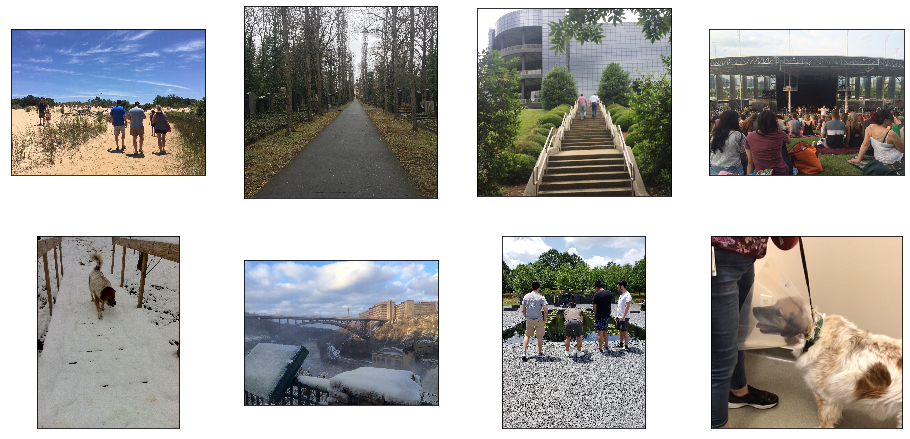

In [6]:
image_table.show(nimages=8,ncol=4,randomize=True)

You can see that the current images are not uniformly sized. The images will be resized in future steps when the SAS DLPy functions `get_image_features()` and `create_embeddings_from_object_detection()` are called. The images are resized according to the individual CNN model requirements. 

For example, the `get_image_features()` function automatically resizes images for use with the VGG-16 CNN model that outputs an image feature table. Similarly, the `create_embeddings_from_object_detection()` function automatically resizes images for use with the YoloV2 Multisize CNN model that outputs a detected objects table. 

<a id = "captions"></a>

### Load Image Captions into SAS CAS

In a prior notebook step, the downloaded image captions file `image_captions.txt` was copied to the client-side folder location specified in `client_image_captioning_root`. 

This step creates a SAS CAS captions table from the content in the downloaded flat file, `image_captions.txt`. The `image_captions.txt` file contains captions for each image in the data, indexed by filename. Once loaded into SAS CAS, the captions table will eventually be merged with the extracted features table and the detected objects table to become a training data table for the final RNN image captioning model.

Concatenate `client_image_captioning_root` with the image captions filename `image_captions.txt` to specify the `captions_path` parameter. You must also specify the delimiter required to parse the caption file. The provided `image_captions.txt` file is tab-delimited.

In [7]:
# Specify the client-side path to the image captions file
captions_path = client_image_captioning_root+'\image_captions.txt'
delimiter = '\t'

The variable `captions_path` points to the location of the client-side image captions file.

Use the DLPy `create_captions_table()` function to create the SAS CAS table `captions`.

<b>Note:</b> The default caption column in the output CAS table is named `Var{}`. You can change the column name `Var{}` to a different one if you prefer, but you must remember to propagate the column name change throughout the rest of the example code.

In [8]:
captions = create_captions_table(s,
                                 captions_path,
                                 delimiter=delimiter,
                                 caption_col_name='Var'
                                )

NOTE: Cloud Analytic Services made the uploaded file available as table TMPPQ62HI8H in caslib CASUSER(UserID).
NOTE: The table TMPPQ62HI8H has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


The `captions` table used in this notebook example contains 5 captions per image (as seen below). A captions table can contain any number of captions; the SAS DLPy `create_captions_table()` function handles the number of captions based on the contents of the source captions file. 

Use the DLPy `head()` function to display a view of the output table `captions`. You can see there are five captions for each image, in columns `Var0` through `Var4`.

In [9]:
captions.head()

,_filename_0,Var0,Var1,Var2,Var3,Var4
0,image34.jpg,a duck begging for food from two women,a woman and her friend watching a duck,a duck lifting its head to two women to get fed,two women feeding a duck,women in winter jackets smiling while giving a...
1,image8.jpg,a girl next to a harbor,a building on a boardwalk,a woman on a boardwalk near a building and water,docks around water with a building on a sunny day,a blonde girl standing near the water
2,image43.jpg,stairs through some trees up to a building,a pathway through the woods leading to a tall ...,two men walking up stair to a building,coworkers walking on a path back to work,several flights of stairs lead up to a large g...
3,image12.jpg,a plaza surrounded by buildings,a man running across a cobblestone plaza,square cobblestone sidewalk near a building,people in a cobblestone plaza,a sidewalk in the middle of the street
4,image23.jpg,a plate of tacos with some beer,some food on a plate sitting on a table,mexican food next to a glass on a table,steak tacos next to another plate of tacos,food on a plate next to a yellow drink


<a id="features"></a>

### Load VGG-16 Model and Generate Image Features Table

The next step creates and uses a VGG-16 CNN model with weights to extract image features. The linear features are extracted in the dense layer of the VGG-16 network for each image and output in an image features table. The VGG-16 model uses the open-source pre-trained .h5 model weights file that you downloaded to the `server_image_captioning_root` folder in an earlier step. 

Each image in a VGG-16 network contains a feature vector with a length of 4096. The features are extracted in the dense layer (the last layer before the output layer) using the DLPy `get_features()` function.

First, load an unweighted VGG-16 model structure into the SAS Viya environment, then import the pre-trained weights file `VGG_ILSVRC_16_layers.caffemodel.h5`. Save the VGG-16 model with pre-trained weights as `features_model`.


In [10]:
# Store concatenated path to pre-trained .h5  
# weights file in variable 'VGG_pretrain_file'
VGG_pretrain_file = server_image_captioning_root+'/VGG_ILSVRC_16_layers.caffemodel.h5'

# Define structure for VGG-16 model 'features_model'
# The model is created to extract input image features.

# VGG-16 Imported model structure
features_model = VGG16(s,
                       model_table='VGG16',
                       
                       # 224 x 224 BGR images
                       n_channels=3,
                       width=224,
                       height=224,
                       
                       # Scaling coefficient of 1
                       scale=1,
                       
                       # Use BGR channel means from training
                       # as BGR offset channel values
                       offsets=image_table.channel_means,
                       
                       # Use pretrained .h5 weights file
                       pre_trained_weights=True,
                       
                       # Path to weights file is stored in VGG_pretrain_file
                       pre_trained_weights_file=VGG_pretrain_file,
                       include_top=True
                      )

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_4ZDL1Y in caslib CASUSER(UserID).
NOTE: The table NEW_LABEL_TABLE_4ZDL1Y has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


Plot the network to visualize the layers. The DLPy `get_image_features()` function requires the name of the dense layer, where features are extracted for images, so plotting the network makes it easier to find the name of this layer. We know that the last layer in the network before the final output layer is the dense layer, where image feature extraction takes place. We will use the network plot to get the layer name.

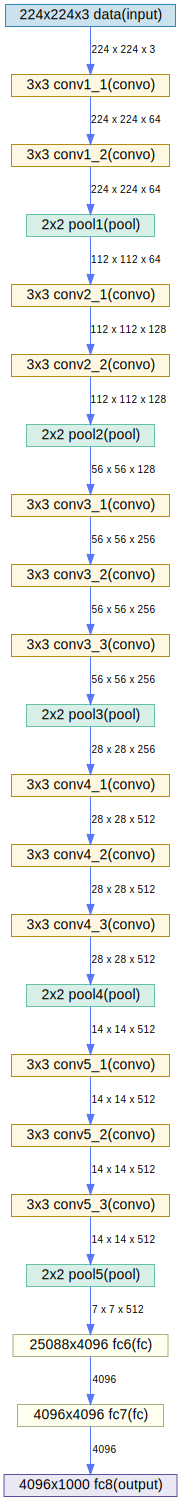

In [11]:
features_model.plot_network()

The network plot reveals the name of the next-to-last network layer (the 4096 x 4096 dense layer) where feature extraction will take place is `fc7`. 

Set the dense layer name `fc7` for extracting features, and specify the target variable name. The target variable name is the name of the column that includes the response variable. This example uses `_filename_0` so the feature vectors can be matched with their files. 

In [12]:
dense_layer = 'fc7'
target_var = '_filename_0'

Now we are ready to generate the extracted features table. The `get_features()` function results in two arrays, `X` and `y`. `X` is an `n by m` size array where `n` is the number of images used for training, and `m` is the size of the feature vector (in this case, m=4096). Array `y` also has length `n` and will contain the corresponding filename for each feature vector. 

The result of this function is an output CAS table of extracted features. The table combines each feature vector with its corresponding filename in each row of the table.

In [13]:
features = get_image_features(s,
                              features_model,
                              image_table,
                              dense_layer=dense_layer,
                              target=target_var)

NOTE: Cloud Analytic Services made the uploaded file available as table TMP3O6EW7R1 in caslib CASUSER(UserID).
NOTE: The table TMP3O6EW7R1 has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


In [14]:
features.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f4087,f4088,f4089,f4090,f4091,f4092,f4093,f4094,f4095,_filename_0
0,0.000000,3.722531,0.000000,0.000000,1.392525,0.000000,0.0,0.422212,0.000000,0.213705,...,0.0,0.000000,0.0,0.0,0.419928,1.381066,0.000000,0.975261,0.00000,image12.jpg
1,2.421685,3.660262,0.000000,0.000000,0.230002,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,2.073687,0.000000,0.000000,0.000000,0.27021,image0.jpg
2,0.856368,1.987478,0.103402,0.000000,2.186595,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.439634,0.0,0.0,1.776672,1.073818,0.465771,0.000000,0.00000,image6.jpg
3,0.128297,3.382427,0.824458,1.821327,2.003314,1.738807,0.0,0.000000,0.000000,0.000000,...,0.0,0.406341,0.0,0.0,2.219067,1.238410,1.933359,0.000000,0.00000,image40.jpg
4,0.917760,1.322629,0.000000,0.441916,0.912015,0.000000,0.0,1.632820,2.250211,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,image33.jpg


<a id = "detection"></a>

### Load the YoloV2 Model and Generate Detected Objects Table

After creating the captions table and the image features table, generate the detected objects table. This section uses an open-source YoloV2 Multisize object detection model wlith trained weights to generate a table that contains the detected objects text parsed into numeric data. 

The YoloV2 model expects 416px by 416px images. An advantage of SAS DLPy is that the example input images for the YoloV2 network are automatically resized by the `create_embeddings_from_object_detection()` function. 

Now use the `client_image_captioning_root` path variable to specify the client-side path to the formatted word vector file you created named `word_embeddings_100.txt`. The word embeddings file is required to map detected object text data into numeric data. 

In [15]:
# Specify the location of the formatted word vector file 
# that you created for object detection embeddings and save 
# it to the variable 'word_embeddings'. In previous code, the 
# full path to the embeddings file word_embeddings_100.txt 
# was saved in the variable 'pretrained_embedding_file'.

word_embeddings = pretrained_embedding_file


Like the previous step that generated an extracted image features table, this step uses a CNN object detection model with trained weights. This example step uses a `.sashdat` file that you downloaded in an earlier step. The `.sashdat` file contains the model and weights information that is required to generate a trained, weighted SAS Viya YoloV2 Multisize CNN model named `detection_model`. 

You can load the model table, weights, and weight attributes in a single call by using the DLPy `Model.load()` function and providing the full path specification to the `yolov2_multisize_313cls/YoloV2_Multisize.sashdat` file.

In [16]:
model_path = server_image_captioning_root+'yolov2_multisize_313cls/YoloV2_Multisize.sashdat'
detection_model = Model(s)
detection_model.load(model_path)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "yolov2_multisize" according to the model name in the table.
NOTE: YoloV2_Multisize_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: YoloV2_Multisize_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


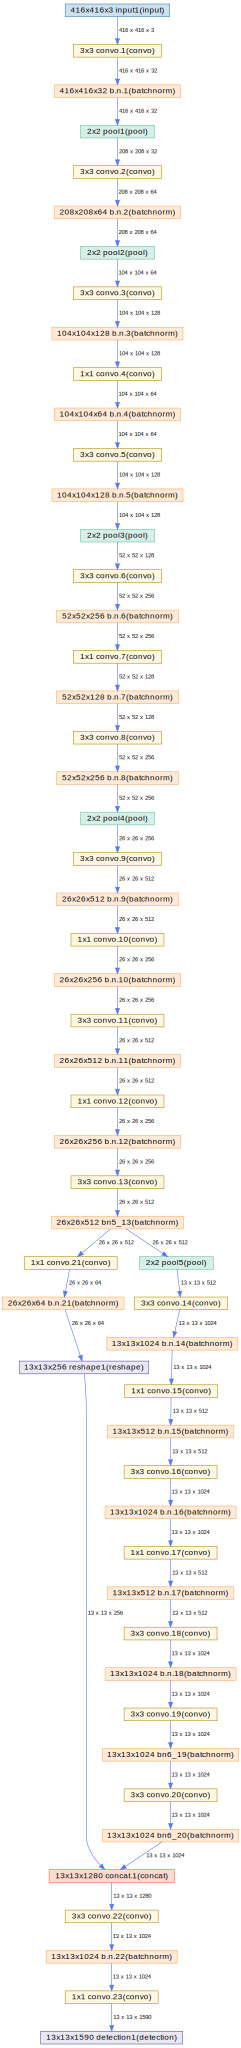

In [17]:
# Display DAG of new Yolov2 model 'detection_model'

detection_model.plot_network()

Use the `predict()` function and the object detection model `detection_model` to generate a scoring table that contains specific objects that were detected in each image. The object text is then parsed into numeric data and becomes the output detected objects table.

In [18]:
# Create Word Embeddings table in SAS CAS
detected_objects = create_embeddings_from_object_detection(s,
                                                           image_table,
                                                           detection_model,
                                                           word_embeddings,
                                                           max_objects=5,
                                                           word_delimiter='\t'
                                                          )

NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'textparse'.
NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(UserID).
NOTE: The table WORD_EMBEDDINGS has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table OBJECTS in caslib CASUSER(UserID).
NOTE: The table OBJECTS has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


In [19]:
detected_objects.head()

,_id_,_Sequence_length_,_F_0_0_,_F_0_1_,_F_0_2_,_F_0_3_,_F_0_4_,_F_0_5_,_F_0_6_,_F_0_7_,...,_F_9_92_,_F_9_93_,_F_9_94_,_F_9_95_,_F_9_96_,_F_9_97_,_F_9_98_,_F_9_99_,_filename_0,first_objects
0,1.0,6.0,-0.12612,0.155640,0.73378,-0.204590,0.447960,0.553180,0.74986,0.044664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image0.jpg,"Laptop,Computer keyboard,Table,NoObject,NoObject,"
1,2.0,6.0,0.33775,0.434280,-0.35509,-0.428670,-0.094258,0.098692,0.59210,0.223610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image1.jpg,"Swimwear,Sports uniform,Person,NoObject,NoObject,"
2,3.0,5.0,0.38709,0.326290,0.64524,0.012882,-0.110510,1.192200,0.37298,0.127260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image10.jpg,"Person,NoObject,NoObject,NoObject,NoObject,"
3,4.0,5.0,-0.18867,-0.040943,0.58878,0.110620,0.142360,0.488500,-0.31832,0.538190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image11.jpg,"House,Plant,House,NoObject,NoObject,"
4,5.0,5.0,0.60050,0.332040,-0.49294,0.754190,0.048023,-0.083043,-0.39718,0.379120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image12.jpg,"Building,Person,Building,Person,Person,"


<a id = "merge"></a>

### Merge Captions, Features, and Detected Objects Tables 

Up to this point, the example has gathered a large amount of data about the images. The image captions are saved in a CAS table named `captions`. The extracted image features are saved in a CAS table named `features`. The detected objects have been saved in a CAS table named `detected_objects`. 

Now, consolidate all of this data into a single CAS table that can be used as training data for the example RNN image captioning model. The `_filename_0` column is common in all three tables (`captions`, `features`, and `detected_objects`), so the tables are merged on the `_filename_0` column.

Start by using the DLPy function `dljoin()` to create the intermediate merge table `captions_features` from `captions` and `features`:

In [20]:
s.dljoin(table=captions,
         annotatedTable=features,
         id = '_filename_0',
         casOut=dict(name='captions_features',
                     replace=True
                    )
        )

,casLib,Name,Rows,Columns,casTable
0,CASUSER(UserID),captions_features,52,4102,"CASTable('captions_features', caslib='CASUSER(..."


Next, use `dljoin()` to merge the intermediate table `captions_features` table with the remaining table `detected_objects`, and create the final consolidated objects-captions-features CAS table named `obj_capt_feats`. 

In [21]:
s.dljoin(table=dict(name='captions_features'),
         annotatedTable=detected_objects,
         id='_filename_0',
         casOut=dict(name='obj_capt_feats',
                     replace=True
                    )
        )

,casLib,Name,Rows,Columns,casTable
0,CASUSER(UserID),obj_capt_feats,52,10178,"CASTable('obj_capt_feats', caslib='CASUSER(chr..."


In [22]:
obj_capt_feats = s.CASTable('obj_capt_feats')

Use the DLPy `head()` function to view the merged tables and verify that the contents merged successfully. The rowID, the filename, the 5 caption sets, the numeric object data, and the image feature vectors are all be present in the merged table `obj_capt_feats`.

<b>Note:</b> The `head()` function does not display thousands of columns. The scrolling display is an abbreviated snapshot, so you will not be able to preview all of the merged table contents.  

In [23]:
obj_capt_feats.head()

,_filename_0,Var0,Var1,Var2,Var3,Var4,f0,f1,f2,f3,...,_Object843_y,_Object843_width,_Object843_height,_Object844_,_P_Object844_,_Object844_x,_Object844_y,_Object844_width,_Object844_height,first_objects
0,image34.jpg,a duck begging for food from two women,a woman and her friend watching a duck,a duck lifting its head to two women to get fed,two women feeding a duck,women in winter jackets smiling while giving a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,
1,image8.jpg,a girl next to a harbor,a building on a boardwalk,a woman on a boardwalk near a building and water,docks around water with a building on a sunny day,a blonde girl standing near the water,1.473509,3.752699,0.0,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Person,Dress,NoObject,NoObject,NoObject,"
2,image43.jpg,stairs through some trees up to a building,a pathway through the woods leading to a tall ...,two men walking up stair to a building,coworkers walking on a path back to work,several flights of stairs lead up to a large g...,0.000000,5.926122,0.0,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Stairs,Tree,Tree,Tree,Tree,"
3,image12.jpg,a plaza surrounded by buildings,a man running across a cobblestone plaza,square cobblestone sidewalk near a building,people in a cobblestone plaza,a sidewalk in the middle of the street,0.000000,3.722531,0.0,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Building,Person,Building,Person,Person,"
4,image23.jpg,a plate of tacos with some beer,some food on a plate sitting on a table,mexican food next to a glass on a table,steak tacos next to another plate of tacos,food on a plate next to a yellow drink,0.000000,1.912627,0.0,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Food,Drink,NoObject,NoObject,NoObject,"


Now that all the data is consolidated in one table `obj_capt_feats`, the table can be reformatted for model training. The RNN model expects input data that has only 1 caption entry per row, but the current table contains 5 captions per row. 

Use the DLPy `reshape_caption_columns()` function with the merged table `obj_capt_feats` to combine caption entries and create a new table named `rnn_input`. Where the original table `obj_capt_feats` contains one row per filename with five caption entries, the new table `rnn_input` will contain the same content organized in five rows with the same filename, with one unique caption per row. 

In [24]:
# Use 'reshape_caption_colunms()' to create a 
# new table 'rnn_input' with one caption per row

rnn_input = reshape_caption_columns(s,
                                    obj_capt_feats,
                                    caption_col_name='Var',
                                    num_captions=5
                                   )

NOTE: Cloud Analytic Services made the uploaded file available as table TMPM2IQWRI9 in caslib CASUSER(UserID).
NOTE: The table TMPM2IQWRI9 has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


Finally, drop the intermediate columns that were used to create the table, but are no longer required, and then use the DLPy `head()` function to view the final table `rnn_input`. This is the data that will be used to train the RNN image captioning model.

In [25]:
# Drop intermediate columns that were used 
# to generate the new table 'rnn_input'
drop_columns = set(rnn_input.columns) - set(features.columns) - set(captions.columns) - set(detected_objects.columns)
drop_columns.remove('caption')
rnn_input.drop(drop_columns,
               axis=1,
               inplace=True
              )

In [26]:
# Use the DLPy 'head()' function to display a 
# view of the new table 'rnn_input'. 
# The new column 'caption' is located at far right.

rnn_input.head()

,_filename_0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,_F_9_92_,_F_9_93_,_F_9_94_,_F_9_95_,_F_9_96_,_F_9_97_,_F_9_98_,_F_9_99_,first_objects,caption
0,image43.jpg,0.0,5.926122,0.0,0.0,1.157194,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Stairs,Tree,Tree,Tree,Tree,",several flights of stairs lead up to a large g...
1,image12.jpg,0.0,3.722531,0.0,0.0,1.392525,0.0,0.000000,0.422212,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Building,Person,Building,Person,Person,",a plaza surrounded by buildings
2,image12.jpg,0.0,3.722531,0.0,0.0,1.392525,0.0,0.000000,0.422212,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Building,Person,Building,Person,Person,",a man running across a cobblestone plaza
3,image23.jpg,0.0,1.912627,0.0,0.0,0.000000,0.0,1.515011,0.000000,2.563832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Food,Drink,NoObject,NoObject,NoObject,",steak tacos next to another plate of tacos
4,image23.jpg,0.0,1.912627,0.0,0.0,0.000000,0.0,1.515011,0.000000,2.563832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Food,Drink,NoObject,NoObject,NoObject,",food on a plate next to a yellow drink


<b>Note:</b> The combined table contains over 5,100 columns. You will not be able to see every column in the abbreviated output display. 

<a id = "oneStep"></a>

### Create Image Captioning Model Training Data in a Single Step 

The first half of this example showed step-by-step how to create an input data table named `rnn_input` that can be used to train an RNN image captioning model. Using the step-by-step approach helps from a learning perspective and can take longer, but also allows for more flexibility during model creation. 

Once you have generated the component captions table, the extracted features table, and the detected objectes table, you can use a simpler one-step method to create an image detection model training table named `rnn_input_single`. The one-step code uses many of the same inputs as the longer method. 

The following code block uses the DLPy `create_captioning_table()` function to create an equivalent training data table (named `rnn_input_single`) in a single step:

In [27]:
# Create RNN image captioning model training input data 
# table 'rnn_input_single' in one compact DLPy code block.
rnn_input_single = create_captioning_table(s,
                                           image_table,
                                           features_model=features_model,
                                           captions_file=captions_path,
                                           obj_detect_model=detection_model,
                                           word_embeddings_file=word_embeddings,
                                           num_captions=5,
                                           dense_layer='fc7',
                                           captions_delimiter='\t',
                                           embeddings_delimiter='\t',
                                           caption_col_name='Var',
                                          )                                           

NOTE: Cloud Analytic Services made the uploaded file available as table TMPB3HGXEQT in caslib CASUSER(UserID).
NOTE: The table TMPB3HGXEQT has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TMPPQQ6NZO7 in caslib CASUSER(UserID).
NOTE: The table TMPPQQ6NZO7 has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table CAPTIONS_FEATURES in caslib CASUSER(UserID).
NOTE: The table CAPTIONS_FEATURES has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'textparse'.
NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(UserID).
NOTE: The table WORD_EMB

An added advantage of using the single-step approach to creating the input training data table for the model is that there is no need to clean up and remove columns from the ouput training data set. The 'create_captioning_table()' function takes care of the housekeeping tasks.

Us the DLPy `head()` function to display a snapshot of the `rnn_input_single` input data:

In [28]:
rnn_input_single.head()

,_id_,_Sequence_length_,_F_0_0_,_F_0_1_,_F_0_2_,_F_0_3_,_F_0_4_,_F_0_5_,_F_0_6_,_F_0_7_,...,f4087,f4088,f4089,f4090,f4091,f4092,f4093,f4094,f4095,caption
0,1.0,5.0,-0.614540,0.89693,0.56771,0.39102,-0.22437,0.490350,0.10868,0.27411,...,0.000000,0.0,0.0,0.0,2.067214,0.000000,0.0,0.000000,0.384699,a laptop and a coffee on a table in a large room
1,1.0,5.0,-0.614540,0.89693,0.56771,0.39102,-0.22437,0.490350,0.10868,0.27411,...,0.000000,0.0,0.0,0.0,2.067214,0.000000,0.0,0.000000,0.384699,"earbuds, a cup of coffee, and a laptop sit on ..."
2,1.0,5.0,-0.614540,0.89693,0.56771,0.39102,-0.22437,0.490350,0.10868,0.27411,...,0.000000,0.0,0.0,0.0,2.067214,0.000000,0.0,0.000000,0.384699,a work setup on a table in an empty room
3,44.0,6.0,0.081465,-1.06310,0.22239,-0.49320,0.42478,-0.031819,-0.84258,0.74030,...,0.689173,0.0,0.0,0.0,0.000000,3.413028,0.0,0.923123,0.192603,cars driving on a curved street on a cloudy day
4,1.0,5.0,-0.614540,0.89693,0.56771,0.39102,-0.22437,0.490350,0.10868,0.27411,...,0.000000,0.0,0.0,0.0,2.067214,0.000000,0.0,0.000000,0.384699,a laptop on a table in a room with lots of cha...


The displayed table contains captions, extracted image features, and detected object embeddings that are sorted by image ID. The table data is equally suitable for use as the input data for RNN model training as the table data that was derived in multiple steps.

<a id = "RNNmodel"></a>

### Use SAS DLPy to Create a SAS Viya RNN Image Captioning Model 

So far, this example has used SAS DLPy with VGG-16 and YoloV2 Multisize models to refine and create training data for an RNN image captioning model. Training data for image captioning models is also called a captioning table. Now that the captioning table has been created, use SAS DLPy to define an RNN model structure that can be trained to perform image captioning. Use the DLPy `ImageCaptioning()` function to create an RNN model named `captioning_model`. By default, the RNN model will have 50 neurons and 3 LSTM layers configured with `samelength` output. 

The RNN model architecture consists of the following:

- Input layer
- Recurrent LSTM layers with same length output
- Recurrent LSTM layer with encoding output
- Recurrent LSTM layer with arbitrary length output
- Output layer

The `max_output_len` parameter is used in the last recurrent layer. It determines the maximum length of the predicted captions. Use the DLPy `get_max_capt_len()` function to get the max caption length from the input training data (captions file) and determine the `max_output_len` parameter value.

In [29]:
# Create SAS Viya RNN model 'captioning_model' 
# with LSTM structure, 50 neurons, 3 blocks.
captioning_model = ImageCaptioning(s,
                                   model_name='image_captioning',
                                   num_blocks=3,
                                   neurons=50,
                                   rnn_type='LSTM',
                                   max_output_len=get_max_capt_len(captions_path)
                                  )

NOTE: Input layer added.
InputLayer added named "input"
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.
OutputLayer added named "output"


Use the `plot_network()` function to view the layout of the new untrained RNN image captioning network `captioning_model`. 

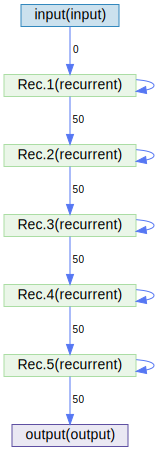

In [30]:
captioning_model.plot_network()

The untrained RNN Image captioning model `captioning_model` has been created. 

If pre-trained weights were available, now would be an appropriate time to load those model weights into the SAS CAS session, and then use the SAS DLPy `set_weights()` function to set the `.sashdat` or `.h5` file weight parameters in the model. 

This example does <b><i>not</b></i> have pre-trained weights for the RNN image captioning model. Instead, the model will be trained from scratch using the training data in the captioning table `rnn_input`.

If pretrained weights were available, the code to import the model weights would resemble the following:

In [ ]:
# Run this step only if you have available 
# pre-trained weights for the RNN image captioning model.

# Load the trained model weights file into 
# SAS CAS as table 'trainedWeights'

# s.loadtable(path='trained_weights.sashdat', 
#             casout=dict(name='trainedWeights', 
#                         replace=True))

# Use table 'trainedWeights to set the weights 
# in the RNN image captioning model

# captioning_model.set_weights('trainedWeights')

# The next step trains the SAS Viya RNN image captioning
# model from scratch, assuming no pre-trained weights 
# were available.

<a id = 'trainRNN'></a>

### Train the SAS Viya RNN Image Captioning Model 

Since there are no available pre-trained weights for the new RNN captioning model, it will be trained from scratch using the data in the newly created captioning table `input_rnn`.

Create a list `input_vars` of columns in the `input_rnn` table that the model will use as input. The training data must be all numeric and should be relevant to the image contents, so the `input_vars` column list will cover all columns in the table <b>except</b> for the columns `caption`, `filename`, `objects`, and `id`. 

After editing the columns in `input_rnn`, the updated table is saved as `input_vars`.

In [31]:
# Clean up intermediate columns used to
# produce the model captioning table 
# 'input_vars'

columns = list(rnn_input.columns)
columns.remove('caption')
columns.remove('_filename_0')
columns.remove('_id_')
columns.remove('first_objects')
input_vars = columns

The image captioning model and the data are finally ready for training. Use the DLPy `fit()` function to train the RNN model `captioning_model`. Since the model takes numeric input and gives text output, it uses a `numericnominal` input layer and a `text` output layer. Use the `word_embeddings` table that was originally loaded for object detection to perform the `init_input_embeddings` in `text_parms`.

The training saves the best weights, which can be used for scoring data later, and uses the following hyperparameter settings:

- learningRate = .01
- mini_batch_size = 20
- max_epochs = 450


In [37]:
# Train the RNN image captioning model named 
# 'captioning_model' using data in 'input_vars'
captioning_model.fit(rnn_input,
                     inputs=input_vars,
                     data_specs=[dict(type='numericnominal',
                                      layer='input',
                                      data=input_vars,
                                      numericNominalParms=dict(tokensize=100)
                                     ),
                                 dict(type='text',
                                      layer='output',
                                    data='caption'
                                     )
                                ],
                     # Save best model weights
                     save_best_weights=True,
                     
                     # Word embeddings files
                     text_parms = TextParms(init_input_embeddings='word_embeddings',
                                            model_output_embeddings=dict(name='word_embeddings_out',
                                                                         replace=True
                                                                        )
                                           ),
                     # Random seed key
                     seed=12345,
                     
                     # Use ADAM optimizer
                     optimizer=Optimizer(algorithm=dict(method='ADAM',
                                                        learningRate=.01
                                                       ),
                                         # Optimization parameters
                                         mini_batch_size=20,
                                         log_level=2,
                                         max_epochs=450                                         ),
                     n_threads=50
                     )

NOTE: Training based on existing weights.
NOTE: Due to data distribution, miniBatchSize has been limited to 14.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 157148.
NOTE:  The approximate memory cost is 874.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       4.00 (s).
NOTE:  The total number of threads on each worker is 50.
NOTE:  The total mini-batch size per thread on each worker is 20.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 1000.
NOTE:  Target variable: caption
NOTE:  Number of levels for the target variable:      1
NOTE:  Levels for the target variable:
NOTE:  Number of input variables:  5097
NOTE:  Number of numeric input variables:   5097
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           6.396     0.9992     0.06
NOTE:  1          0.01           6.011     0.9962     0.06
NOTE:  2          0.01           5.699     0.9733    

NOTE:  124        0.01          0.7424     0.1584     0.05
NOTE:  125        0.01          0.7468     0.1599     0.05
NOTE:  126        0.01          0.7398     0.1571     0.05
NOTE:  127        0.01          0.7374      0.153     0.05
NOTE:  128        0.01          0.7302     0.1571     0.05
NOTE:  129        0.01          0.7153     0.1488     0.05
NOTE:  130        0.01          0.7115      0.153     0.05
NOTE:  131        0.01          0.7078     0.1551     0.05
NOTE:  132        0.01          0.7073     0.1498     0.05
NOTE:  133        0.01          0.7036     0.1546     0.05
NOTE:  134        0.01          0.6908     0.1493     0.05
NOTE:  135        0.01          0.6791     0.1507     0.05
NOTE:  136        0.01          0.6885     0.1506     0.05
NOTE:  137        0.01          0.6794     0.1499     0.05
NOTE:  138        0.01          0.6754     0.1464     0.05
NOTE:  139        0.01          0.6721     0.1431     0.05
NOTE:  140        0.01          0.6681     0.1416     0.

NOTE:  266        0.01          0.4179      0.115     0.05
NOTE:  267        0.01          0.4271     0.1165     0.05
NOTE:  268        0.01          0.4232      0.114     0.05
NOTE:  269        0.01          0.4247      0.114     0.05
NOTE:  270        0.01          0.4195     0.1137     0.05
NOTE:  271        0.01          0.4169     0.1178     0.05
NOTE:  272        0.01          0.4202     0.1172     0.06
NOTE:  273        0.01           0.418     0.1194     0.05
NOTE:  274        0.01          0.4113     0.1142     0.05
NOTE:  275        0.01          0.4202     0.1132     0.05
NOTE:  276        0.01          0.4201     0.1172     0.05
NOTE:  277        0.01          0.4185     0.1186     0.05
NOTE:  278        0.01          0.4189     0.1168     0.05
NOTE:  279        0.01          0.4116     0.1168     0.05
NOTE:  280        0.01          0.4114     0.1173     0.05
NOTE:  281        0.01          0.4148      0.111     0.05
NOTE:  282        0.01          0.4093     0.1135     0.

NOTE:  408        0.01          0.3428     0.1016     0.06
NOTE:  409        0.01          0.3518     0.1071     0.05
NOTE:  410        0.01           0.346     0.1013     0.05
NOTE:  411        0.01          0.3443     0.1047     0.05
NOTE:  412        0.01          0.3393     0.1064     0.05
NOTE:  413        0.01          0.3479     0.1081     0.05
NOTE:  414        0.01          0.3459     0.1074     0.05
NOTE:  415        0.01          0.3472      0.105     0.05
NOTE:  416        0.01           0.344     0.1052     0.05
NOTE:  417        0.01          0.3421      0.104     0.05
NOTE:  418        0.01          0.3435     0.1054     0.05
NOTE:  419        0.01          0.3413     0.1054     0.05
NOTE:  420        0.01          0.3366     0.1005     0.05
NOTE:  421        0.01          0.3407      0.107     0.05
NOTE:  422        0.01          0.3378     0.1042     0.05
NOTE:  423        0.01          0.3382     0.1045     0.05
NOTE:  424        0.01          0.3421     0.1065     0.

,Descr,Value
0,Model Name,image_captioning
1,Model Type,Recurrent Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,5
9,Number of Weight Parameters,155650


<a id = 'scoreCaptioningTable'></a>
 
 ### Use the SAS Viya RNN Captioning Model to Score the Captioning Table 

Now use the SAS DLPy `predict()` function with the SAS Viya model `captioning_model` to use the best training weights to score the captioning table data. The scoring task generates captioning text based on extracted features in the input image data. 

In [38]:
# Use RNN image captioning model 'captioning_model'
# to score the captioning table 'rnn_input'
captioning_model.predict(rnn_input,
                         text_parms=dict(initOutputEmbeddings='word_embeddings_out',
                                         hasOutputTermIds=True,
                                         initInputEmbeddings='word_embeddings',
                                         hasInputTermIds=False,
                                         embeddingTrainable=False
                                        ),
                          use_best_weights=True
                         )

NOTE: Using the weights providing the smallest loss error.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           240
 1  Number of Observations Used           240
 2  Misclassification Error (%)      78.26664
 3                   Loss Error      8.479096

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(UserID)  Valid_Res_FpYkfH   240     5949   
 
                                             casTable  
 0  CASTable('Valid_Res_FpYkfH', caslib='CASUSER(c...  

+ Elapsed: 5.04s, user: 5.11s, sys: 2.66s, mem: 1.07e+03mb

Save the results from scoring the captions table in a file named `results`. You can use `results` to show caption predictions for the scored images. 

In [39]:
# Save the image captioning model validation 
# results in a table named 'results'.

results = captioning_model.valid_res_tbl

Use the DLPy `head()` function to view the output table and verify the final results. The caption predictions are in the column `_DL_Pred_` to the right of the `caption` column.

In [40]:
results.head()

,_filename_0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,_P_Object838_,_P_Object839_,_P_Object840_,_P_Object841_,_P_Object842_,_P_Object843_,_P_Object844_,first_objects,caption,_DL_Pred_
0,image21.jpg,0.064232,1.351239,0.000000,0.000000,0.128891,0.982013,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cat,Person,NoObject,NoObject,NoObject,",a woman giving a dog a treat,a woman giving a dog a treat
1,image21.jpg,0.064232,1.351239,0.000000,0.000000,0.128891,0.982013,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cat,Person,NoObject,NoObject,NoObject,",a fluffy white dog lying on the floor near a w...,a woman giving a dog a treat
2,image21.jpg,0.064232,1.351239,0.000000,0.000000,0.128891,0.982013,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cat,Person,NoObject,NoObject,NoObject,",a woman in a dining room crouches down to give...,a woman giving a dog a treat
3,image1.jpg,0.000000,3.334584,1.075493,0.000000,0.000000,0.000000,0.0,3.550407,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Swimwear,Sports uniform,Person,NoObject,NoObject,",a young boy walking on a sidwalk next to a pool,a boy in a blue shirt and orange shorts walkin...
4,image28.jpg,0.000000,5.527038,1.406251,0.530414,0.683266,0.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"House,Tree,Tree,Tree,NoObject,","beautiful winter sunset in a quiet, snowy neig...",a plate of tacos with some beer


<a id="displayPredictions"></a>

### Display Image Captioning Model Predictions

Use the SAS DLPy `display_predicted_image_captions()` function to display some of the results from the scored table. You must use a client-side path specification to the scored table. You can configure the number of images to display and the number of columns in the output table. By default, the function also displays the top 5 objects that were detected in the image, the 5 ground truth captions, and the predicted caption. 

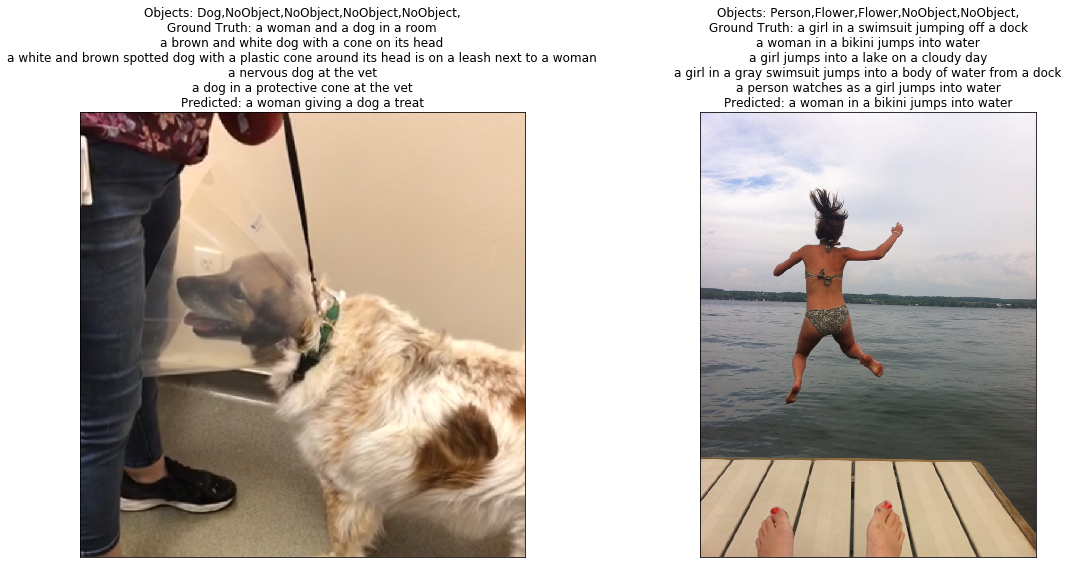

In [41]:
# Display random scored images and captions
image_path = client_image_captioning_image_root
display_predicted_image_captions(s,
                                 results,
                                 npreds=2,
                                 ncol=2,
                                 img_path=image_path
                                )